# Research question

"Can we predict future levels of inflation? And if so, what measures could forecast, or (if a plausible mechanism is found) cause higher inflation?"

# Motivation

Excessive inflation has for long been a severe problem not just for economists, but mostly for regular economy participants. It has often indirectly been the cause for recessions and prolonged periods of static economic growth. Kept at bay for some time, it appears to have resurfaced among the major developed economies amid a rapid recovery from the COVID-induced recession and the war in Ukraine.

Debate around inflation, specifically about its prevention, should resurface too. Prevention, along with accurate prediction, seems key, especially as the current mechanism for bringing inflation down (raising interest rates) has time and time again proven to be hurtful for the economy as a whole. Identifying forecasting indicators or even causal mechanisms would go a long way in preventing future surges in price growth.

# Method and data

### The data

To answer the research question I wil be using Federal Reserve (US) data on inflation (CPI) and 8 other economic indicators spanning 60 years, collected quarterly, from 1962 to 2022.

The data can be considered representative to the population of interest (EU), as the United States is widely viewed as a model version of a developed, free-market economy. The conclusions derived from this dataset will most certainly be of great insight to other countries as well.

Data was stored in the data/ folder and download from https://fred.stlouisfed.org. Download links are listed in sources.txt.

I use pandas to read the .csv variable files, and then I merge the observations together on the 'DATE' column. I rename the columns and create several, additional variables by transforming existing ones.

First, I create target variables, starting with CPI1, which indicates the next-quarter (target) inflation rate for all current-quarter variables. To add this column to my dataframe, I get rid of my last column, for which target inflation (CPI1) cannot be given. Based on CPI1, I create other target variables: CPIY1, which rounds the CPI1 value to an integer; CPIY2, which indicates whether the inflation rate has risen or fallen (quarter to quarter); and CPIY3, which groups inflation rates into 4 quantiles.

Afterwards, I create past-value variables. The motivation for this is simple. When trying to predict inflation or GDP, one does not only look at the most recent measure, but also at the overarching trend and/or figures from the previous quarters. When analysing causal pathways to inflation, measures from previous quarters must be considered too, as transmission in an economy does not happen solely on a quarter to quarter basis. I create 5 past-value variables for each variable in my dataframe. To add them to my dataframe, I get rid of my first 5 columns, for which 5 past quarter values cannot be synthesized.

Lastly, I create a standardized version of my dataframe.

### Methods

In order to answer the first part of the research question ("Can we predict future levels of inflation?"), I will use a neural network model to try and predict next-quarter inflation (CPIY1, CPIY2 and CPIY3) based on current and past-quarter measures of 9 variables.

To answer the second part of the research question ("What measures could forecast or cause higher inflation?"), I will use Lasso regressions and conduct a Bayesian analysis.

# Preview of the answers

Future (next-quarter) levels of inflation can be predicted with around 50% probability. This probability rises to even 67% when trying to predict the category (low, moderate, elevated or alarming) into which the inflation rate falls.

Apart from previous-quarter CPI and PPI measures, the personal savings rate, GDP and government spending all exhibit a significant amount of pressure on the target inflation measure.

Moreover, Lasso regressions show a correlation between current (Q0) market yield on 10-year U.S Treasury bonds and next-quarter inflation.

# Main assumptions

As this analysis is being conducted using U.S data, the biggest assumption needed to generalize the conclusions of this study to other (e.g European) countries, is the assumption that market mechanisms are the same or at least highly similar for other developed, free-market economies.

Moreover, it is assumed that the data was gathered in a professional manner, in accordance with the general principles of statistics.

# Python code


In [3]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce
from scipy import stats, optimize, special
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import pymc as pm
import arviz as az

#### Downloading the data from my repository, then merging and renaming the columns

In [4]:
cpi = pd.read_csv("data/CPIAUCSL.csv")
ppico = pd.read_csv("data/PPIACO.csv")
gdp = pd.read_csv("data/GDPC1.csv")
unemp = pd.read_csv("data/UNRATE.csv")
govspend = pd.read_csv("data/FGEXPND.csv")
savings = pd.read_csv("data/PSAVERT.csv")
prod = pd.read_csv("data/PRS85006091.csv")
aaa = pd.read_csv("data/AAA.csv")
ts10 = pd.read_csv("data/DGS10.csv")

In [5]:
from functools import reduce

dfs = [cpi, ppico, gdp, unemp, govspend, aaa, ts10, savings, prod]
df = reduce(lambda left, right: left.merge(right, on="DATE", how="inner"), dfs)

df = df.rename({
    'PPIACO_PC1':'PPI0',
    'CPIAUCSL_PC1':'CPI0',
    'GDPC1_PC1':'GDP0',
    'UNRATE':'U0',
    'FGEXPND_PC1':'GOVSPEND0',
    'DGS10':'BOND0',
    'PSAVERT':'S0',
    'PRS85006091':'PROD0',
    'DATE':'DATE0',
    'AAA':'AAA0'
}, axis='columns')

## Creating target variables from CPI1

In [6]:
cpipred = []
for i in range(1, len(df['CPI0'])):
    cpipred.append(df['CPI0'][i])
cpipred = pd.DataFrame (cpipred, columns = ['CPI1'])

df = df.iloc[:-1 , :]
df = pd.concat([df, cpipred], axis=1)
df = df. T. drop_duplicates(). T
df.insert(0, 'CPI1', df.pop('CPI1'))
df

,CPI1,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,AAA0,BOND0,S0,PROD0
0,1.23995,1962-01-01,1.1059,-0.31447,7.56728,5.6,9.78344,4.39,3.86,11.3,7.0
1,1.46765,1962-04-01,1.23995,0.63898,6.72769,5.5,7.62818,4.28,4.0,11.7,3.8
2,1.23292,1962-07-01,1.46765,1.26984,6.00401,5.6,8.77395,4.32,3.94,11.6,3.8
3,1.12695,1962-10-01,1.23292,0.0,4.3071,5.5,8.90023,4.24,3.85,11.3,3.7
4,1.32406,1963-01-01,1.12695,-0.63091,3.59787,5.7,5.81773,4.19,3.95,10.9,2.3
...,...,...,...,...,...,...,...,...,...,...,...
235,2.65838,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,2.26,0.93,13.6,2.7
236,5.34102,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,3.04,1.74,19.9,3.9
237,5.38991,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,2.79,1.45,12.6,2.2
238,7.09654,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,2.53,1.52,10.5,-0.4


### Creating target variables: CPIY1
CPI1 is created by rounding to the nearest integer. We add 1 to make sure there are no negative values in the column. This is necessary since neural networks do not accept target variable categories smaller than 0.  Since we don't have an inflation (deflation) value smaller than -1.5, adding 1 is enough.

In [7]:
df['CPI1'] = df['CPI1'].astype(float)
df['CPIY1'] = df['CPI1'].round() +1
df.insert(1, 'CPIY1', df.pop('CPIY1'))
df

,CPI1,CPIY1,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,AAA0,BOND0,S0,PROD0
0,1.23995,2.0,1962-01-01,1.1059,-0.31447,7.56728,5.6,9.78344,4.39,3.86,11.3,7.0
1,1.46765,2.0,1962-04-01,1.23995,0.63898,6.72769,5.5,7.62818,4.28,4.0,11.7,3.8
2,1.23292,2.0,1962-07-01,1.46765,1.26984,6.00401,5.6,8.77395,4.32,3.94,11.6,3.8
3,1.12695,2.0,1962-10-01,1.23292,0.0,4.3071,5.5,8.90023,4.24,3.85,11.3,3.7
4,1.32406,2.0,1963-01-01,1.12695,-0.63091,3.59787,5.7,5.81773,4.19,3.95,10.9,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...
235,2.65838,4.0,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,2.26,0.93,13.6,2.7
236,5.34102,6.0,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,3.04,1.74,19.9,3.9
237,5.38991,6.0,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,2.79,1.45,12.6,2.2
238,7.09654,8.0,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,2.53,1.52,10.5,-0.4


In [8]:
df['CPIY1'].nunique()

17

### Creating target variables: CPIY2
CPIY2 equals 1 if inflation has increased and 0 if it has decreased or stayed the same.

In [9]:
df['CPIY2'] = np.where(df['CPI1'] > df['CPI0'], 1, 0)
df.insert(2, 'CPIY2', df.pop('CPIY2'))
df

,CPI1,CPIY1,CPIY2,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,AAA0,BOND0,S0,PROD0
0,1.23995,2.0,1,1962-01-01,1.1059,-0.31447,7.56728,5.6,9.78344,4.39,3.86,11.3,7.0
1,1.46765,2.0,1,1962-04-01,1.23995,0.63898,6.72769,5.5,7.62818,4.28,4.0,11.7,3.8
2,1.23292,2.0,0,1962-07-01,1.46765,1.26984,6.00401,5.6,8.77395,4.32,3.94,11.6,3.8
3,1.12695,2.0,0,1962-10-01,1.23292,0.0,4.3071,5.5,8.90023,4.24,3.85,11.3,3.7
4,1.32406,2.0,1,1963-01-01,1.12695,-0.63091,3.59787,5.7,5.81773,4.19,3.95,10.9,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2.65838,4.0,1,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,2.26,0.93,13.6,2.7
236,5.34102,6.0,1,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,3.04,1.74,19.9,3.9
237,5.38991,6.0,1,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,2.79,1.45,12.6,2.2
238,7.09654,8.0,1,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,2.53,1.52,10.5,-0.4


### Creating target variables: CPIY3
CPIY3 separates CPI1 into 4 equal groups; quartiles, representing respectively low, moderate, elevated and alarming levels of inflation.

In [10]:
df['CPI1'].quantile([0.25, 0.5, 0.75])

,CPI1
0.25,1.931145
0.50,3.001215
0.75,4.761660


In [11]:
df['CPIY3'] = pd.qcut(df["CPI1"], 4, labels=[0,1,2,3])
df.insert(3, 'CPIY3', df.pop('CPIY3'))
df

,CPI1,CPIY1,CPIY2,CPIY3,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,AAA0,BOND0,S0,PROD0
0,1.23995,2.0,1,0,1962-01-01,1.1059,-0.31447,7.56728,5.6,9.78344,4.39,3.86,11.3,7.0
1,1.46765,2.0,1,0,1962-04-01,1.23995,0.63898,6.72769,5.5,7.62818,4.28,4.0,11.7,3.8
2,1.23292,2.0,0,0,1962-07-01,1.46765,1.26984,6.00401,5.6,8.77395,4.32,3.94,11.6,3.8
3,1.12695,2.0,0,0,1962-10-01,1.23292,0.0,4.3071,5.5,8.90023,4.24,3.85,11.3,3.7
4,1.32406,2.0,1,0,1963-01-01,1.12695,-0.63091,3.59787,5.7,5.81773,4.19,3.95,10.9,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2.65838,4.0,1,1,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,2.26,0.93,13.6,2.7
236,5.34102,6.0,1,3,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,3.04,1.74,19.9,3.9
237,5.38991,6.0,1,3,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,2.79,1.45,12.6,2.2
238,7.09654,8.0,1,3,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,2.53,1.52,10.5,-0.4


## Creating explanatory variables - 5 past quarters for all variables
The observation indexed 5 will become the first observation in our dataframe, as it is the first observation for which we have a full (5) set of past observations.

In [12]:
df.head(7)

,CPI1,CPIY1,CPIY2,CPIY3,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,AAA0,BOND0,S0,PROD0
0,1.23995,2.0,1,0,1962-01-01,1.1059,-0.31447,7.56728,5.6,9.78344,4.39,3.86,11.3,7.0
1,1.46765,2.0,1,0,1962-04-01,1.23995,0.63898,6.72769,5.5,7.62818,4.28,4.0,11.7,3.8
2,1.23292,2.0,0,0,1962-07-01,1.46765,1.26984,6.00401,5.6,8.77395,4.32,3.94,11.6,3.8
3,1.12695,2.0,0,0,1962-10-01,1.23292,0.0,4.3071,5.5,8.90023,4.24,3.85,11.3,3.7
4,1.32406,2.0,1,0,1963-01-01,1.12695,-0.63091,3.59787,5.7,5.81773,4.19,3.95,10.9,2.3
5,0.98619,2.0,0,0,1963-04-01,1.32406,0.31746,3.82216,5.6,3.94545,4.23,4.0,10.7,3.5
6,1.64582,3.0,1,0,1963-07-01,0.98619,-0.94044,4.81693,5.5,4.07336,4.31,4.07,10.1,4.3


In [13]:
vars_to_lag = ["CPI0", "PPI0", "GDP0", "U0", "GOVSPEND0", "AAA0", "BOND0", "S0", "PROD0"]

for var in vars_to_lag:
    for lag in range(1, 6):
        df[f"{var[:-1]}-{lag}"] = df[var].shift(lag)

In [14]:
df = df.iloc[5: , :]
df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)
df = df. T. drop_duplicates(). T
df

/tmp/ipython-input-906077598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('index', inplace=True, axis=1)


,CPI1,CPIY1,CPIY2,CPIY3,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,0.98619,2.0,0,0,1963-04-01,1.32406,0.31746,3.82216,5.6,3.94545,...,10.9,11.3,11.6,11.7,11.3,2.3,3.7,3.8,3.8,7.0
1,1.64582,3.0,1,0,1963-07-01,0.98619,-0.94044,4.81693,5.5,4.07336,...,10.7,10.9,11.3,11.6,11.7,3.5,2.3,3.7,3.8,3.8
2,1.40937,2.0,0,0,1963-10-01,1.64582,0.0,5.15824,5.5,4.40262,...,10.1,10.7,10.9,11.3,11.6,4.3,3.5,2.3,3.7,3.8
3,1.30676,2.0,0,0,1964-01-01,1.40937,0.31746,6.21582,5.4,5.09562,...,11.5,10.1,10.7,10.9,11.3,3.5,4.3,3.5,2.3,3.7
4,1.17188,2.0,0,0,1964-04-01,1.30676,-0.31646,6.18075,5.2,6.0126,...,10.7,11.5,10.1,10.7,10.9,4.0,3.5,4.3,3.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2.65838,4.0,1,1,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,...,18.7,33.8,7.8,7.4,7.0,3.7,2.5,0.9,2.4,2.1
231,5.34102,6.0,1,3,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,...,13.6,18.7,33.8,7.8,7.4,2.7,3.7,2.5,0.9,2.4
232,5.38991,6.0,1,3,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,...,19.9,13.6,18.7,33.8,7.8,3.9,2.7,3.7,2.5,0.9
233,7.09654,8.0,1,3,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,...,12.6,19.9,13.6,18.7,33.8,2.2,3.9,2.7,3.7,2.5


## Standardizing the dataframe

In [15]:
def standardize(x):
    return (x-x.mean())/x.std()

#### Dropping variables that cannot or should not be standardized (these will be added later on)

In [16]:
dfprep = df.loc[:, df.columns !='DATE0']
dfprep = dfprep.loc[:, dfprep.columns !='CPIY1']
dfprep = dfprep.loc[:, dfprep.columns !='CPIY2']
dfprep = dfprep.loc[:, dfprep.columns !='CPIY3']
dfprep

,CPI1,CPI0,PPI0,GDP0,U0,GOVSPEND0,AAA0,BOND0,S0,PROD0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,0.98619,1.32406,0.31746,3.82216,5.6,3.94545,4.23,4.0,10.7,3.5,...,10.9,11.3,11.6,11.7,11.3,2.3,3.7,3.8,3.8,7.0
1,1.64582,0.98619,-0.94044,4.81693,5.5,4.07336,4.31,4.07,10.1,4.3,...,10.7,10.9,11.3,11.6,11.7,3.5,2.3,3.7,3.8,3.8
2,1.40937,1.64582,0.0,5.15824,5.5,4.40262,4.35,4.14,11.5,3.5,...,10.1,10.7,10.9,11.3,11.6,4.3,3.5,2.3,3.7,3.8
3,1.30676,1.40937,0.31746,6.21582,5.4,5.09562,4.38,4.23,10.7,4.0,...,11.5,10.1,10.7,10.9,11.3,3.5,4.3,3.5,2.3,3.7
4,1.17188,1.30676,-0.31646,6.18075,5.2,6.0126,4.41,4.15,12.4,3.7,...,10.7,11.5,10.1,10.7,10.9,4.0,3.5,4.3,3.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2.65838,1.27815,0.75377,-2.26292,6.7,23.45544,2.26,0.93,13.6,2.7,...,18.7,33.8,7.8,7.4,7.0,3.7,2.5,0.9,2.4,2.1
231,5.34102,2.65838,11.34127,0.54698,6.0,64.41446,3.04,1.74,19.9,3.9,...,13.6,18.7,33.8,7.8,7.4,2.7,3.7,2.5,0.9,2.4
232,5.38991,5.34102,19.71757,12.22668,5.9,-17.74758,2.79,1.45,12.6,2.2,...,19.9,13.6,18.7,33.8,7.8,3.9,2.7,3.7,2.5,0.9
233,7.09654,5.38991,20.55141,4.94656,4.7,-8.9697,2.53,1.52,10.5,-0.4,...,12.6,19.9,13.6,18.7,33.8,2.2,3.9,2.7,3.7,2.5


In [17]:
dfst = standardize(dfprep)
dfst.to_pickle("data/dfst.dat") # save
dfst

,CPI1,CPI0,PPI0,GDP0,U0,GOVSPEND0,AAA0,BOND0,S0,PROD0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,-1.013164,-0.887464,-0.594512,0.354718,-0.226025,-0.420087,-1.038334,-0.653092,0.53574,0.939277,...,0.588425,0.701144,0.788772,0.844262,0.732848,0.198748,1.052994,1.107655,1.10825,3.00956
1,-0.781688,-1.00652,-0.823908,0.758893,-0.285706,-0.405377,-1.008829,-0.630038,0.364527,1.432253,...,0.531379,0.587117,0.703154,0.815137,0.849705,0.938153,0.188419,1.046061,1.10825,1.075871
2,-0.864663,-0.774084,-0.652405,0.897568,-0.285706,-0.367508,-0.994077,-0.606984,0.764024,0.939277,...,0.36024,0.530104,0.588998,0.727761,0.820491,1.431089,0.929484,0.183736,1.046637,1.075871
3,-0.900671,-0.857403,-0.594512,1.327262,-0.345386,-0.287806,-0.983013,-0.577344,0.53574,1.247387,...,0.759563,0.359064,0.53192,0.61126,0.732848,0.938153,1.423526,0.922871,0.184053,1.015444
4,-0.948002,-0.89356,-0.710116,1.313013,-0.464748,-0.182344,-0.971948,-0.603691,1.020845,1.062521,...,0.531379,0.758158,0.360685,0.553009,0.61599,1.246238,0.929484,1.415629,0.92341,0.169455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,-0.426363,-0.903641,-0.514944,-2.11765,0.430463,1.823762,-1.76489,-1.664172,1.363271,0.446301,...,2.813224,7.115159,-0.295713,-0.408126,-0.523374,1.061387,0.31193,-0.67859,0.245666,0.048599
231,0.515024,-0.417285,1.415842,-0.975988,0.012698,6.53447,-1.477218,-1.397405,3.161012,1.185765,...,1.358548,2.810642,7.124447,-0.291625,-0.406516,0.445216,1.052994,0.306925,-0.678531,0.229883
232,0.532181,0.528007,2.943384,3.769475,-0.046983,-2.915009,-1.569421,-1.492915,1.077916,0.138191,...,3.155501,1.356799,2.815046,7.280958,-0.289658,1.184621,0.435441,1.046061,0.307279,-0.676534
233,1.131068,0.545235,3.095447,0.811562,-0.763151,-1.905462,-1.665312,-1.469861,0.478669,-1.463982,...,1.073317,3.152723,1.359553,2.883035,7.306099,0.137131,1.176505,0.430114,1.046637,0.29031


#### Adding the non-standardized variables back to the dataframe and moving them to the front

In [18]:
cols_to_add = ["CPIY1", "CPIY2", "CPIY3", "DATE0"]
dfst[cols_to_add] = df[cols_to_add]
dfst = dfst[["CPIY1", "CPIY2", "CPIY3", "DATE0"] + [c for c in dfst.columns if c not in cols_to_add]]
dfst.head()

,CPIY1,CPIY2,CPIY3,DATE0,CPI1,CPI0,PPI0,GDP0,U0,GOVSPEND0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,2.0,0,0,1963-04-01,-1.013164,-0.887464,-0.594512,0.354718,-0.226025,-0.420087,...,0.588425,0.701144,0.788772,0.844262,0.732848,0.198748,1.052994,1.107655,1.10825,3.00956
1,3.0,1,0,1963-07-01,-0.781688,-1.00652,-0.823908,0.758893,-0.285706,-0.405377,...,0.531379,0.587117,0.703154,0.815137,0.849705,0.938153,0.188419,1.046061,1.10825,1.075871
2,2.0,0,0,1963-10-01,-0.864663,-0.774084,-0.652405,0.897568,-0.285706,-0.367508,...,0.36024,0.530104,0.588998,0.727761,0.820491,1.431089,0.929484,0.183736,1.046637,1.075871
3,2.0,0,0,1964-01-01,-0.900671,-0.857403,-0.594512,1.327262,-0.345386,-0.287806,...,0.759563,0.359064,0.53192,0.61126,0.732848,0.938153,1.423526,0.922871,0.184053,1.015444
4,2.0,0,0,1964-04-01,-0.948002,-0.89356,-0.710116,1.313013,-0.464748,-0.182344,...,0.531379,0.758158,0.360685,0.553009,0.61599,1.246238,0.929484,1.415629,0.92341,0.169455


## Introducing the data
The data spans from 1962 to 2022. In the plot below, the green line indicates the inflation target (2%) and the red line (5%) indicates levels above which inflation is perceived to be excessive.

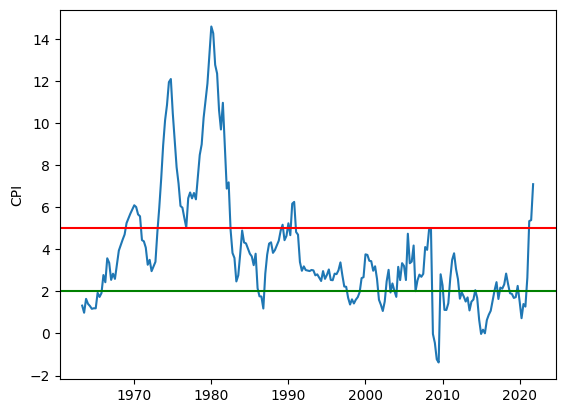

<Figure size 800x500 with 0 Axes>

In [19]:
dates = df['DATE0']
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(x, df['CPI0'])
plt.axhline(y=2, color='g', linestyle='-')
plt.axhline(y=5, color='r', linestyle='-')
plt.ylabel("CPI")
plt.figure(figsize=(8, 5))
plt.tight_layout()

The dangers of excessive inflation can be seen on the next plot, where CPI is combined with GDP figures. In several periods the measures mirror each other: high inflation is combined with low or even negative GDP.

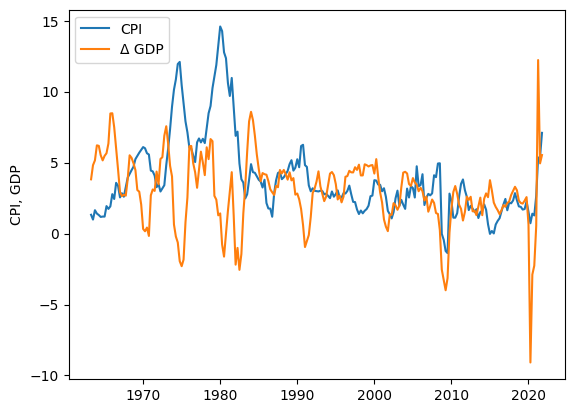

<Figure size 800x500 with 0 Axes>

In [20]:
plt.plot(x, df['CPI0'], label='CPI')
plt.plot(x, df['GDP0'], label='Δ GDP')
plt.ylabel("CPI, GDP")
plt.legend()
plt.figure(figsize=(8, 5))
plt.tight_layout()

Neural networks, Lasso regressions and Bayesian models will be used to discover the nature of inflation.

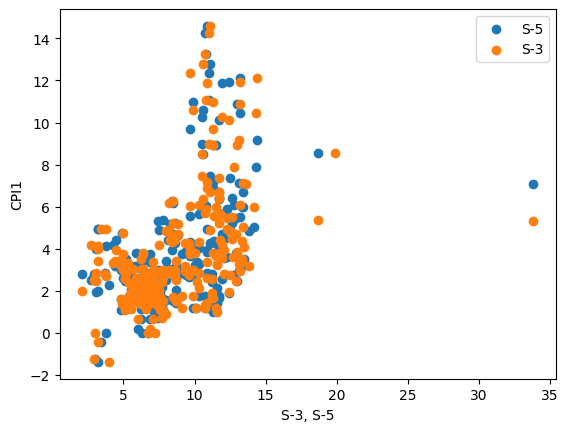

<Figure size 800x500 with 0 Axes>

In [21]:
scatter = plt.scatter(df['S-5'],df['CPI1'], label='S-5')
scatter = plt.scatter(df['S-3'],df['CPI1'], label='S-3')
plt.legend()
plt.xlabel("S-3, S-5")
plt.ylabel("CPI1")
plt.figure(figsize=(8, 5))
plt.tight_layout()

In [22]:
df['CPI1'] = pd.to_numeric(df['CPI1'], errors='coerce')
df['CPIY4'] = pd.qcut(df['CPI1'], 2, labels=[1,2])
df['CPI1'].quantile([0.5])

,CPI1
0.5,3.01941


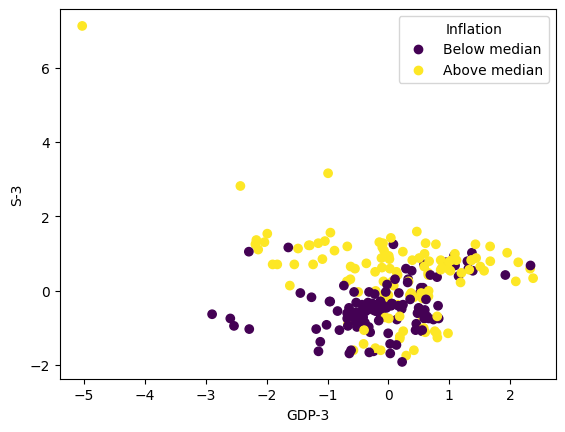

<Figure size 800x500 with 0 Axes>

In [23]:
names = ['Below median', 'Above median']
scatter = plt.scatter(dfst['GDP-3'],dfst['S-3'],c=df['CPIY4'])
plt.legend(handles=scatter.legend_elements()[0],
           labels=names,
           title="Inflation")
plt.xlabel("GDP-3")
plt.ylabel("S-3")
plt.figure(figsize=(8, 5))
plt.tight_layout()

We won't be using CPIY4 anymore, so we can drop it from the dataframe.

In [24]:
df = df.drop(columns='CPIY4')

## Neural networks
Neural networks are used to create a model for the prediction of next-quarter infaltion, using current, as well as past-quarter variables. These include the CPI index itself, the Producer Price Index (PPI), real GDP, the unemployment rate, government expenditures, the yield on AAA-rated corporate bonds, the yield on 10-year U.S Treasury bonds, the personal savings rate and labor productivity.
The models will be used to predict 3 types of targets:
1. CPIY1: rounded inflation rate
2. CPIY2: rise or fall in the inflation rate
3. CPIY3: category of inflation rate (low, moderate, elevated or alarming)

Models will be used on standardized and non-standardized explanatory variables.

### Predicting CPIY1 with non-standardized variables
CPIY1 consists of 17 categories, each containing values within the scope of 1 percentage point of inflation. For example, 6.7% inflation is denoted with the number 8, 4.2% with 5 and so on. Hence, we are testing the rate at which the neural network can correctly predict the percent-wide category into which next-quarter inflation lands.

In [25]:
df['CPIY1'].nunique()

17

#### Creating x (explanatory) and Y (target) arrays

In [26]:
df

,CPI1,CPIY1,CPIY2,CPIY3,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,0.98619,2.0,0,0,1963-04-01,1.32406,0.31746,3.82216,5.6,3.94545,...,10.9,11.3,11.6,11.7,11.3,2.3,3.7,3.8,3.8,7.0
1,1.64582,3.0,1,0,1963-07-01,0.98619,-0.94044,4.81693,5.5,4.07336,...,10.7,10.9,11.3,11.6,11.7,3.5,2.3,3.7,3.8,3.8
2,1.40937,2.0,0,0,1963-10-01,1.64582,0.0,5.15824,5.5,4.40262,...,10.1,10.7,10.9,11.3,11.6,4.3,3.5,2.3,3.7,3.8
3,1.30676,2.0,0,0,1964-01-01,1.40937,0.31746,6.21582,5.4,5.09562,...,11.5,10.1,10.7,10.9,11.3,3.5,4.3,3.5,2.3,3.7
4,1.17188,2.0,0,0,1964-04-01,1.30676,-0.31646,6.18075,5.2,6.0126,...,10.7,11.5,10.1,10.7,10.9,4.0,3.5,4.3,3.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2.65838,4.0,1,1,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,...,18.7,33.8,7.8,7.4,7.0,3.7,2.5,0.9,2.4,2.1
231,5.34102,6.0,1,3,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,...,13.6,18.7,33.8,7.8,7.4,2.7,3.7,2.5,0.9,2.4
232,5.38991,6.0,1,3,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,...,19.9,13.6,18.7,33.8,7.8,3.9,2.7,3.7,2.5,0.9
233,7.09654,8.0,1,3,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,...,12.6,19.9,13.6,18.7,33.8,2.2,3.9,2.7,3.7,2.5


In [27]:
X = df.iloc[:,5:]
X = np.asarray(X).astype('float32')
X

array([[ 1.32406,  0.31746,  3.82216, ...,  3.8    ,  3.8    ,  7.     ],
       [ 0.98619, -0.94044,  4.81693, ...,  3.7    ,  3.8    ,  3.8    ],
       [ 1.64582,  0.     ,  5.15824, ...,  2.3    ,  3.7    ,  3.8    ],
       ...,
       [ 5.34102, 19.71757, 12.22668, ...,  3.7    ,  2.5    ,  0.9    ],
       [ 5.38991, 20.55141,  4.94656, ...,  2.7    ,  3.7    ,  2.5    ],
       [ 7.09654, 20.36808,  5.53348, ...,  3.9    ,  2.7    ,  3.7    ]],
      dtype=float32)

In [28]:
y = df.iloc[:,1]
y = np.asarray(y).astype('float32')
y

array([ 2.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  3.,  5.,
        4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,
        7.,  7.,  7.,  7.,  5.,  5.,  5.,  4.,  5.,  4.,  4.,  4.,  6.,
        7.,  8., 10., 11., 12., 13., 13., 11., 10.,  9.,  8.,  7.,  7.,
        6.,  6.,  7.,  8.,  7.,  8.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 16., 15., 14., 13., 12., 11., 12., 10.,  8.,  8.,  6.,  5.,
        5.,  3.,  4.,  5.,  6.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  3.,
        3.,  3.,  2.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,
        5.,  6.,  6.,  6.,  7.,  7.,  6.,  6.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  2.,  3.,  2.,  3.,  3.,
        3.,  4.,  4.,  5.,  5.,  4.,  4.,  4.,  4.,  4.,  3.,  2.,  2.,
        3.,  3.,  4.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  6.,
        4.,  4.,  5.,  3.,  4.,  4.,  4.,  4.,  5.,  5.,  6.,  6

#### Splitting the variables into train and test sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=36)

In [30]:
X_train[0]

array([ 2.6764 ,  4.07166,  4.82763,  4.     ,  3.34171,  7.55   ,
        6.45   ,  4.4    ,  4.2    ,  2.62997,  1.9656 ,  1.7284 ,
        1.60692,  1.4268 ,  3.39257,  0.32051, -1.68404, -3.15457,
       -2.90196,  4.80021,  4.72753,  4.82186,  4.87954,  4.09777,
        4.2    ,  4.3    ,  4.2    ,  4.4    ,  4.6    ,  3.05652,
        1.96699,  2.44223,  1.54854,  1.73842,  7.39   ,  7.23   ,
        6.62   ,  6.22   ,  6.4    ,  5.9    ,  5.81   ,  5.25   ,
        4.65   ,  4.44   ,  4.8    ,  5.     ,  6.4    ,  6.2    ,
        6.9    ,  3.5    ,  3.9    ,  4.1    ,  3.6    ,  3.3    ],
      dtype=float32)

In [31]:
y_test[3]

np.float32(11.0)

#### Defining the relu and softmax functions

In [32]:
def relu(x):
    return np.clip(x,0,np.inf)
def softmax(x):
    return [np.exp(x[i])/np.sum(np.exp(x)) for i in range(len(x))]

#### Defining the model

In [33]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape= (54,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(17, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Running the model

In [34]:
model.fit(X_train, y_train, epochs=150)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTest accuracy:', test_acc)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0248 - loss: 8.5257   
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1746 - loss: 5.1786
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1776 - loss: 3.1267
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3007 - loss: 3.2276
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3266 - loss: 2.3579
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3472 - loss: 2.4044
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3643 - loss: 2.1045 
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4130 - loss: 1.8030 
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4205 - loss: 1.7516
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4114 - loss: 1.6835 
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4624 - loss: 1.6148
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4829 

The model is correct in predicting future levels of inflation around half of the time.

#### Train and validation loss

In [35]:
history = model.fit(X_train,
                    y_train,
                    epochs=150,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9634 - loss: 0.2494 - val_accuracy: 0.4366 - val_loss: 2.5669
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9451 - loss: 0.2803 - val_accuracy: 0.4648 - val_loss: 2.5613
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8963 - loss: 0.3083 - val_accuracy: 0.4648 - val_loss: 2.5576
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8963 - loss: 0.3167 - val_accuracy: 0.4366 - val_loss: 2.5524
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9207 - loss: 0.3023 - val_accuracy: 0.4648 - val_loss: 2.5523
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9390 - loss: 0.2751 - val_accuracy: 0.4507 - val_loss: 2.5674
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9451 - loss: 0.2511 - val_accuracy: 0.4507 - val_loss: 2.6038
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9512 - loss: 0.2408 - val_accuracy: 0.4507 - val_lo

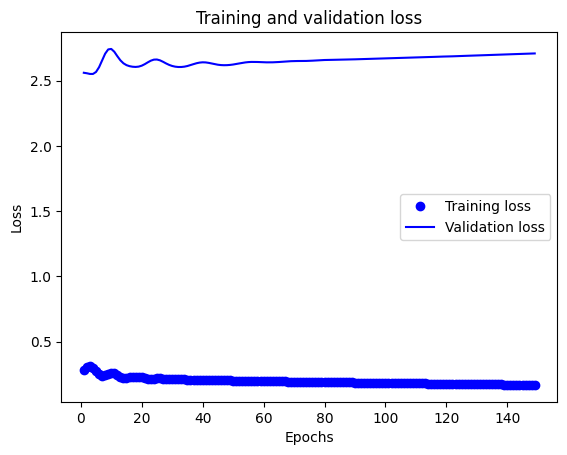

In [36]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Not a lot of variance in training and validation loss over the course of epochs, although both show modest trends: training loss converging to lower values and validation loss rising slightly.

Although rising validation loss may be a sign of overfitting, training loss changes at a similar, almost unnoticeable pace. The number of epochs is justified, as it allows the model to achieve the greatest accuracy, with only a slight risk of overfitting.

### Predicting CPIY1 with standardized variables

#### Creating x (explanatory) arrays

In [37]:
dfst

,CPIY1,CPIY2,CPIY3,DATE0,CPI1,CPI0,PPI0,GDP0,U0,GOVSPEND0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,2.0,0,0,1963-04-01,-1.013164,-0.887464,-0.594512,0.354718,-0.226025,-0.420087,...,0.588425,0.701144,0.788772,0.844262,0.732848,0.198748,1.052994,1.107655,1.10825,3.00956
1,3.0,1,0,1963-07-01,-0.781688,-1.00652,-0.823908,0.758893,-0.285706,-0.405377,...,0.531379,0.587117,0.703154,0.815137,0.849705,0.938153,0.188419,1.046061,1.10825,1.075871
2,2.0,0,0,1963-10-01,-0.864663,-0.774084,-0.652405,0.897568,-0.285706,-0.367508,...,0.36024,0.530104,0.588998,0.727761,0.820491,1.431089,0.929484,0.183736,1.046637,1.075871
3,2.0,0,0,1964-01-01,-0.900671,-0.857403,-0.594512,1.327262,-0.345386,-0.287806,...,0.759563,0.359064,0.53192,0.61126,0.732848,0.938153,1.423526,0.922871,0.184053,1.015444
4,2.0,0,0,1964-04-01,-0.948002,-0.89356,-0.710116,1.313013,-0.464748,-0.182344,...,0.531379,0.758158,0.360685,0.553009,0.61599,1.246238,0.929484,1.415629,0.92341,0.169455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,4.0,1,1,2020-10-01,-0.426363,-0.903641,-0.514944,-2.11765,0.430463,1.823762,...,2.813224,7.115159,-0.295713,-0.408126,-0.523374,1.061387,0.31193,-0.67859,0.245666,0.048599
231,6.0,1,3,2021-01-01,0.515024,-0.417285,1.415842,-0.975988,0.012698,6.53447,...,1.358548,2.810642,7.124447,-0.291625,-0.406516,0.445216,1.052994,0.306925,-0.678531,0.229883
232,6.0,1,3,2021-04-01,0.532181,0.528007,2.943384,3.769475,-0.046983,-2.915009,...,3.155501,1.356799,2.815046,7.280958,-0.289658,1.184621,0.435441,1.046061,0.307279,-0.676534
233,8.0,1,3,2021-07-01,1.131068,0.545235,3.095447,0.811562,-0.763151,-1.905462,...,1.073317,3.152723,1.359553,2.883035,7.306099,0.137131,1.176505,0.430114,1.046637,0.29031


In [38]:
X = dfst.iloc[:,5:]
X = np.asarray(X).astype('float32')
X

array([[-0.8874638 , -0.5945117 ,  0.35471815, ...,  1.1076554 ,
         1.1082497 ,  3.0095599 ],
       [-1.0065203 , -0.82390827,  0.75889325, ...,  1.0460607 ,
         1.1082497 ,  1.0758713 ],
       [-0.7740841 , -0.6524052 ,  0.8975676 , ...,  0.18373555,
         1.0466366 ,  1.0758713 ],
       ...,
       [ 0.528007  ,  2.9433837 ,  3.7694752 , ...,  1.0460607 ,
         0.30727908, -0.6765338 ],
       [ 0.5452345 ,  3.0954466 ,  0.81156194, ...,  0.43011418,
         1.0466366 ,  0.2903104 ],
       [ 1.146606  ,  3.0620136 ,  1.0500276 , ...,  1.16925   ,
         0.4305053 ,  1.0154436 ]], dtype=float32)

In [39]:
y

array([ 2.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  3.,  5.,
        4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,
        7.,  7.,  7.,  7.,  5.,  5.,  5.,  4.,  5.,  4.,  4.,  4.,  6.,
        7.,  8., 10., 11., 12., 13., 13., 11., 10.,  9.,  8.,  7.,  7.,
        6.,  6.,  7.,  8.,  7.,  8.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 16., 15., 14., 13., 12., 11., 12., 10.,  8.,  8.,  6.,  5.,
        5.,  3.,  4.,  5.,  6.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  3.,
        3.,  3.,  2.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,
        5.,  6.,  6.,  6.,  7.,  7.,  6.,  6.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  2.,  3.,  2.,  3.,  3.,
        3.,  4.,  4.,  5.,  5.,  4.,  4.,  4.,  4.,  4.,  3.,  2.,  2.,
        3.,  3.,  4.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  6.,
        4.,  4.,  5.,  3.,  4.,  4.,  4.,  4.,  5.,  5.,  6.,  6

No need to standardize the target variable

#### Splitting the variables into train and test sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=96)

#### Defining the relu and softmax functions

In [41]:
def relu(x):
    return np.clip(x,0,np.inf)
def softmax(x):
    return [np.exp(x[i])/np.sum(np.exp(x)) for i in range(len(x))]

#### Defining the model

In [42]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape= (54,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(17, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Running the model

In [43]:
model.fit(X_train, y_train, epochs=150)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTest accuracy:', test_acc)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0271 - loss: 2.9436
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1648 - loss: 2.5034 
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3595 - loss: 2.2603 
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4420 - loss: 1.9816 
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5042 - loss: 1.8067 
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5078 - loss: 1.6900 
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5036 - loss: 1.6571 
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5141 - loss: 1.5539 
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5583 - loss: 1.4556 
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5700 - loss: 1.3939 
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5913 - loss: 1.3501 
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5769 - loss

The model with standardized variables is roughly as accurate as the one without.

#### Train and validation loss

In [44]:
history = model.fit(X_train,
                    y_train,
                    epochs=150,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9817 - loss: 0.1820 - val_accuracy: 0.5211 - val_loss: 2.3696
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9817 - loss: 0.1815 - val_accuracy: 0.5211 - val_loss: 2.3701
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9817 - loss: 0.1810 - val_accuracy: 0.5211 - val_loss: 2.3709
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9817 - loss: 0.1806 - val_accuracy: 0.5211 - val_loss: 2.3719
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9817 - loss: 0.1801 - val_accuracy: 0.5211 - val_loss: 2.3731
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9817 - loss: 0.1797 - val_accuracy: 0.5211 - val_loss: 2.3744
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9878 - loss: 0.1793 - val_accuracy: 0.5211 - val_loss: 2.3759
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9878 - loss: 0.1788 - val_accuracy: 0.5211 - v

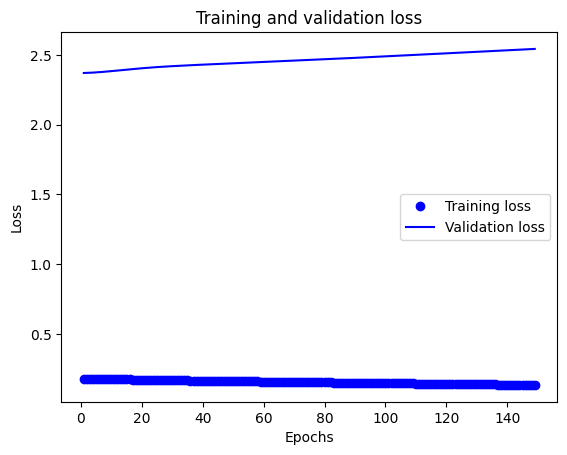

In [45]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training and validation loss trends are similar to the model with non-standardized variables.

### Predicting CPIY2 with non-standardized variables
CPIY2 indicates whether inflation (as measured by CPI1) has risen in comparison to the last quarter (CPI0): 1 indicates growth, 0 indicates decline in the inflation rate. Hence, we are testing the rate at which the neural network can correctly predict whether inflation will rise or fall.

#### Creating the y (target) and X (explanatory) arrays

In [46]:
df

,CPI1,CPIY1,CPIY2,CPIY3,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,0.98619,2.0,0,0,1963-04-01,1.32406,0.31746,3.82216,5.6,3.94545,...,10.9,11.3,11.6,11.7,11.3,2.3,3.7,3.8,3.8,7.0
1,1.64582,3.0,1,0,1963-07-01,0.98619,-0.94044,4.81693,5.5,4.07336,...,10.7,10.9,11.3,11.6,11.7,3.5,2.3,3.7,3.8,3.8
2,1.40937,2.0,0,0,1963-10-01,1.64582,0.0,5.15824,5.5,4.40262,...,10.1,10.7,10.9,11.3,11.6,4.3,3.5,2.3,3.7,3.8
3,1.30676,2.0,0,0,1964-01-01,1.40937,0.31746,6.21582,5.4,5.09562,...,11.5,10.1,10.7,10.9,11.3,3.5,4.3,3.5,2.3,3.7
4,1.17188,2.0,0,0,1964-04-01,1.30676,-0.31646,6.18075,5.2,6.0126,...,10.7,11.5,10.1,10.7,10.9,4.0,3.5,4.3,3.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2.65838,4.0,1,1,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,...,18.7,33.8,7.8,7.4,7.0,3.7,2.5,0.9,2.4,2.1
231,5.34102,6.0,1,3,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,...,13.6,18.7,33.8,7.8,7.4,2.7,3.7,2.5,0.9,2.4
232,5.38991,6.0,1,3,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,...,19.9,13.6,18.7,33.8,7.8,3.9,2.7,3.7,2.5,0.9
233,7.09654,8.0,1,3,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,...,12.6,19.9,13.6,18.7,33.8,2.2,3.9,2.7,3.7,2.5


In [47]:
y = df.iloc[:,2]
y = np.asarray(y).astype('float32')
y

array([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 1.

In [48]:
X = df.iloc[:,5:]
X = np.asarray(X).astype('float32')
X

array([[ 1.32406,  0.31746,  3.82216, ...,  3.8    ,  3.8    ,  7.     ],
       [ 0.98619, -0.94044,  4.81693, ...,  3.7    ,  3.8    ,  3.8    ],
       [ 1.64582,  0.     ,  5.15824, ...,  2.3    ,  3.7    ,  3.8    ],
       ...,
       [ 5.34102, 19.71757, 12.22668, ...,  3.7    ,  2.5    ,  0.9    ],
       [ 5.38991, 20.55141,  4.94656, ...,  2.7    ,  3.7    ,  2.5    ],
       [ 7.09654, 20.36808,  5.53348, ...,  3.9    ,  2.7    ,  3.7    ]],
      dtype=float32)

#### Splitting the variables into train and test sets

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

#### Defining the relu and softmax functions

In [50]:
def relu(x):
    return np.clip(x,0,np.inf)
def softmax(x):
    return [np.exp(x[i])/np.sum(np.exp(x)) for i in range(len(x))]

#### Defining the model

In [51]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape= (54,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Running the model

In [52]:
model.fit(X_train, y_train, epochs=75)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTest accuracy:', test_acc)

Epoch 1/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5388 - loss: 1.5148  
Epoch 2/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5785 - loss: 0.8743 
Epoch 3/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5656 - loss: 0.7682 
Epoch 4/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6290 - loss: 0.6181 
Epoch 5/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6825 - loss: 0.6686 
Epoch 6/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6167 - loss: 0.6123 
Epoch 7/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6987 - loss: 0.5604 
Epoch 8/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6852 - loss: 0.5319 
Epoch 9/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6846 - loss: 0.5320 
Epoch 10/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6953 - loss: 0.4949 
Epoch 11/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6878 - loss: 0.5247  
Epoch 12/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7100 - loss: 0.5435 

The model is correct in predicting whether inflation will rise or fall slightly more than half of the time.

#### Train and validation loss

In [53]:
history = model.fit(X_train,
                    y_train,
                    epochs=75,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9146 - loss: 0.2647 - val_accuracy: 0.5352 - val_loss: 1.1873
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9146 - loss: 0.2678 - val_accuracy: 0.5352 - val_loss: 1.1968
Epoch 3/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9146 - loss: 0.2688 - val_accuracy: 0.5775 - val_loss: 1.1874
Epoch 4/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9207 - loss: 0.2662 - val_accuracy: 0.5915 - val_loss: 1.1649
Epoch 5/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9207 - loss: 0.2619 - val_accuracy: 0.5775 - val_loss: 1.1391
Epoch 6/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9268 - loss: 0.2593 - val_accuracy: 0.5775 - val_loss: 1.1177
Epoch 7/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9329 - loss: 0.2594 - val_accuracy: 0.5915 - val_loss: 1.1042
Epoch 8/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2609 - val_accuracy: 0.5915 - val_loss: 1.09

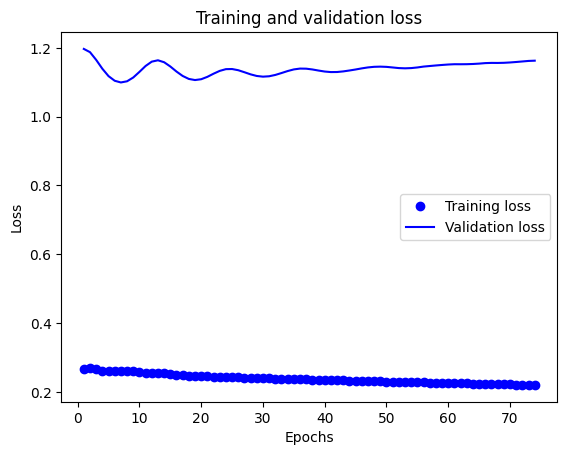

In [54]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The lower number of epochs (75) is justified due to the nature of the target variable, which includes only two values. Much less training is required than in the case of CPIY1, which included 17 unique variables to choose from. This allows to minimize the risk of overfitting, while keeping training loss low as well, as illustrated by the validation loss plot.

### Predicting CPIY2 with standardized variables

#### Creating x (explanatory) arrays

In [55]:
dfst

,CPIY1,CPIY2,CPIY3,DATE0,CPI1,CPI0,PPI0,GDP0,U0,GOVSPEND0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,2.0,0,0,1963-04-01,-1.013164,-0.887464,-0.594512,0.354718,-0.226025,-0.420087,...,0.588425,0.701144,0.788772,0.844262,0.732848,0.198748,1.052994,1.107655,1.10825,3.00956
1,3.0,1,0,1963-07-01,-0.781688,-1.00652,-0.823908,0.758893,-0.285706,-0.405377,...,0.531379,0.587117,0.703154,0.815137,0.849705,0.938153,0.188419,1.046061,1.10825,1.075871
2,2.0,0,0,1963-10-01,-0.864663,-0.774084,-0.652405,0.897568,-0.285706,-0.367508,...,0.36024,0.530104,0.588998,0.727761,0.820491,1.431089,0.929484,0.183736,1.046637,1.075871
3,2.0,0,0,1964-01-01,-0.900671,-0.857403,-0.594512,1.327262,-0.345386,-0.287806,...,0.759563,0.359064,0.53192,0.61126,0.732848,0.938153,1.423526,0.922871,0.184053,1.015444
4,2.0,0,0,1964-04-01,-0.948002,-0.89356,-0.710116,1.313013,-0.464748,-0.182344,...,0.531379,0.758158,0.360685,0.553009,0.61599,1.246238,0.929484,1.415629,0.92341,0.169455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,4.0,1,1,2020-10-01,-0.426363,-0.903641,-0.514944,-2.11765,0.430463,1.823762,...,2.813224,7.115159,-0.295713,-0.408126,-0.523374,1.061387,0.31193,-0.67859,0.245666,0.048599
231,6.0,1,3,2021-01-01,0.515024,-0.417285,1.415842,-0.975988,0.012698,6.53447,...,1.358548,2.810642,7.124447,-0.291625,-0.406516,0.445216,1.052994,0.306925,-0.678531,0.229883
232,6.0,1,3,2021-04-01,0.532181,0.528007,2.943384,3.769475,-0.046983,-2.915009,...,3.155501,1.356799,2.815046,7.280958,-0.289658,1.184621,0.435441,1.046061,0.307279,-0.676534
233,8.0,1,3,2021-07-01,1.131068,0.545235,3.095447,0.811562,-0.763151,-1.905462,...,1.073317,3.152723,1.359553,2.883035,7.306099,0.137131,1.176505,0.430114,1.046637,0.29031


In [56]:
X = dfst.iloc[:,5:]
X = np.asarray(X).astype('float32')
X

array([[-0.8874638 , -0.5945117 ,  0.35471815, ...,  1.1076554 ,
         1.1082497 ,  3.0095599 ],
       [-1.0065203 , -0.82390827,  0.75889325, ...,  1.0460607 ,
         1.1082497 ,  1.0758713 ],
       [-0.7740841 , -0.6524052 ,  0.8975676 , ...,  0.18373555,
         1.0466366 ,  1.0758713 ],
       ...,
       [ 0.528007  ,  2.9433837 ,  3.7694752 , ...,  1.0460607 ,
         0.30727908, -0.6765338 ],
       [ 0.5452345 ,  3.0954466 ,  0.81156194, ...,  0.43011418,
         1.0466366 ,  0.2903104 ],
       [ 1.146606  ,  3.0620136 ,  1.0500276 , ...,  1.16925   ,
         0.4305053 ,  1.0154436 ]], dtype=float32)

In [57]:
y

array([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 1.

#### Splitting the variables into train and test sets

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=29)

#### Defining the relu and softmax functions

In [59]:
def relu(x):
    return np.clip(x,0,np.inf)
def softmax(x):
    return [np.exp(x[i])/np.sum(np.exp(x)) for i in range(len(x))]

#### Defining the model

In [60]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape= (54,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Running the model

In [61]:
model.fit(X_train, y_train, epochs=75)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTest accuracy:', test_acc)

Epoch 1/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5804 - loss: 0.6901  
Epoch 2/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6591 - loss: 0.6058 
Epoch 3/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6977 - loss: 0.5529 
Epoch 4/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6937 - loss: 0.5496 
Epoch 5/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7337 - loss: 0.5227 
Epoch 6/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7292 - loss: 0.5063 
Epoch 7/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7248 - loss: 0.5199 
Epoch 8/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7052 - loss: 0.5357 
Epoch 9/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7426 - loss: 0.4755 
Epoch 10/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7566 - loss: 0.4637 
Epoch 11/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7743 - loss: 0.4824 
Epoch 12/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7645 - loss: 0.4688  

The model with standardized variables is roughly as accurate as the one without.

#### Train and validation loss

In [62]:
history = model.fit(X_train,
                    y_train,
                    epochs=75,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9451 - loss: 0.2179 - val_accuracy: 0.5634 - val_loss: 1.0706
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9390 - loss: 0.2175 - val_accuracy: 0.5634 - val_loss: 1.0717
Epoch 3/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9390 - loss: 0.2173 - val_accuracy: 0.5493 - val_loss: 1.0726
Epoch 4/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9390 - loss: 0.2171 - val_accuracy: 0.5493 - val_loss: 1.0731
Epoch 5/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9390 - loss: 0.2169 - val_accuracy: 0.5493 - val_loss: 1.0733
Epoch 6/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9390 - loss: 0.2167 - val_accuracy: 0.5493 - val_loss: 1.0732
Epoch 7/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9390 - loss: 0.2165 - val_accuracy: 0.5493 - val_loss: 1.0727
Epoch 8/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9390 - loss: 0.2161 - val_accuracy: 0.5493 - val_loss:

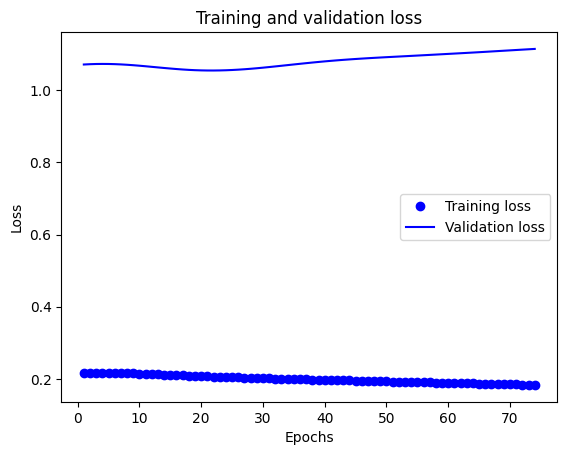

In [63]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training and validation loss values are similar to the model with non-standardized variables, although the plot for standardized variables shows much less variance in training and validation loss for the first epochs.

### Predicting CPIY3 with non-standardized variables
For this variable, the neural network will try to predict one of four quantiles in which target inflation lands.

#### Creating the y (target) and X (explanatory) arrays

In [64]:
df

,CPI1,CPIY1,CPIY2,CPIY3,DATE0,CPI0,PPI0,GDP0,U0,GOVSPEND0,...,S-1,S-2,S-3,S-4,S-5,PROD-1,PROD-2,PROD-3,PROD-4,PROD-5
0,0.98619,2.0,0,0,1963-04-01,1.32406,0.31746,3.82216,5.6,3.94545,...,10.9,11.3,11.6,11.7,11.3,2.3,3.7,3.8,3.8,7.0
1,1.64582,3.0,1,0,1963-07-01,0.98619,-0.94044,4.81693,5.5,4.07336,...,10.7,10.9,11.3,11.6,11.7,3.5,2.3,3.7,3.8,3.8
2,1.40937,2.0,0,0,1963-10-01,1.64582,0.0,5.15824,5.5,4.40262,...,10.1,10.7,10.9,11.3,11.6,4.3,3.5,2.3,3.7,3.8
3,1.30676,2.0,0,0,1964-01-01,1.40937,0.31746,6.21582,5.4,5.09562,...,11.5,10.1,10.7,10.9,11.3,3.5,4.3,3.5,2.3,3.7
4,1.17188,2.0,0,0,1964-04-01,1.30676,-0.31646,6.18075,5.2,6.0126,...,10.7,11.5,10.1,10.7,10.9,4.0,3.5,4.3,3.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2.65838,4.0,1,1,2020-10-01,1.27815,0.75377,-2.26292,6.7,23.45544,...,18.7,33.8,7.8,7.4,7.0,3.7,2.5,0.9,2.4,2.1
231,5.34102,6.0,1,3,2021-01-01,2.65838,11.34127,0.54698,6.0,64.41446,...,13.6,18.7,33.8,7.8,7.4,2.7,3.7,2.5,0.9,2.4
232,5.38991,6.0,1,3,2021-04-01,5.34102,19.71757,12.22668,5.9,-17.74758,...,19.9,13.6,18.7,33.8,7.8,3.9,2.7,3.7,2.5,0.9
233,7.09654,8.0,1,3,2021-07-01,5.38991,20.55141,4.94656,4.7,-8.9697,...,12.6,19.9,13.6,18.7,33.8,2.2,3.9,2.7,3.7,2.5


In [65]:
y = df.iloc[:,3]
y = np.asarray(y).astype('float32')
y

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 2., 2., 1., 1., 1.,
       2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2.,
       2., 1., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 1., 1., 2., 3., 2., 2.,
       2., 2., 2., 2., 2., 1., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 2.,
       3., 3., 2., 2., 3., 2., 3., 3., 3., 2., 2., 1., 2., 2., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 1., 2., 1.,
       0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 2., 1., 2., 2., 1., 2., 2.,
       2., 2., 1., 1., 1., 1., 1., 2., 2., 3., 3., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 2., 2., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1.

In [66]:
X = df.iloc[:,5:]
X = np.asarray(X).astype('float32')
X

array([[ 1.32406,  0.31746,  3.82216, ...,  3.8    ,  3.8    ,  7.     ],
       [ 0.98619, -0.94044,  4.81693, ...,  3.7    ,  3.8    ,  3.8    ],
       [ 1.64582,  0.     ,  5.15824, ...,  2.3    ,  3.7    ,  3.8    ],
       ...,
       [ 5.34102, 19.71757, 12.22668, ...,  3.7    ,  2.5    ,  0.9    ],
       [ 5.38991, 20.55141,  4.94656, ...,  2.7    ,  3.7    ,  2.5    ],
       [ 7.09654, 20.36808,  5.53348, ...,  3.9    ,  2.7    ,  3.7    ]],
      dtype=float32)

#### Splitting the variables into train and test sets

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=20)

#### Defining the relu and softmax functions

In [68]:
def relu(x):
    return np.clip(x,0,np.inf)
def softmax(x):
    return [np.exp(x[i])/np.sum(np.exp(x)) for i in range(len(x))]

#### Defining the model

In [69]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape= (54,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Running the model

In [70]:
model.fit(X_train, y_train, epochs=125)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTest accuracy:', test_acc)

Epoch 1/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1599 - loss: 3.3956
Epoch 2/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3644 - loss: 2.0419
Epoch 3/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4908 - loss: 1.5153 
Epoch 4/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4995 - loss: 1.2768  
Epoch 5/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5819 - loss: 1.0098 
Epoch 6/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5450 - loss: 1.1499 
Epoch 7/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6071 - loss: 1.0654 
Epoch 8/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6376 - loss: 0.8467 
Epoch 9/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6115 - loss: 0.9427 
Epoch 10/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6002 - loss: 0.8409 
Epoch 11/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6259 - loss: 0.7830 
Epoch 12/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6566 - l

The model is correct in predicting the future inlfation group even two-thirds of the time.

#### Train and validation loss

In [71]:
history = model.fit(X_train,
                    y_train,
                    epochs=125,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9817 - loss: 0.1664 - val_accuracy: 0.6338 - val_loss: 0.9356
Epoch 2/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9756 - loss: 0.1705 - val_accuracy: 0.6338 - val_loss: 0.9543
Epoch 3/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9756 - loss: 0.1755 - val_accuracy: 0.6338 - val_loss: 0.9625
Epoch 4/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9695 - loss: 0.1775 - val_accuracy: 0.6338 - val_loss: 0.9571
Epoch 5/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9756 - loss: 0.1749 - val_accuracy: 0.6056 - val_loss: 0.9413
Epoch 6/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9817 - loss: 0.1689 - val_accuracy: 0.6479 - val_loss: 0.9227
Epoch 7/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9817 - loss: 0.1630 - val_accuracy: 0.6479 - val_loss: 0.9083
Epoch 8/125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9817 - loss: 0.1597 - val_accuracy: 0.6338 - val_lo

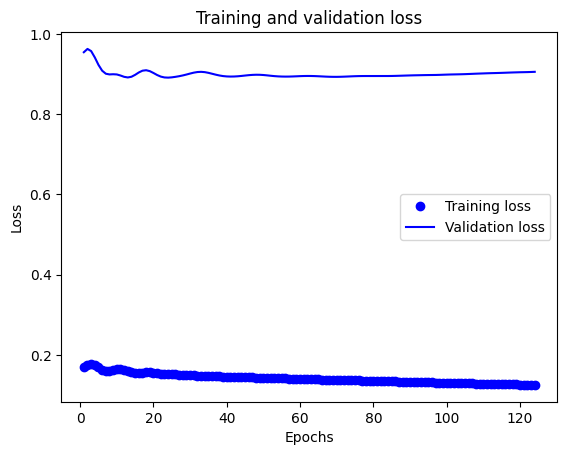

In [72]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predicting CPIY3 with standardized variables

#### Creating X (explanatory) arrays

In [73]:
X = dfst.iloc[:,5:]
X = np.asarray(X).astype('float32')
X

array([[-0.8874638 , -0.5945117 ,  0.35471815, ...,  1.1076554 ,
         1.1082497 ,  3.0095599 ],
       [-1.0065203 , -0.82390827,  0.75889325, ...,  1.0460607 ,
         1.1082497 ,  1.0758713 ],
       [-0.7740841 , -0.6524052 ,  0.8975676 , ...,  0.18373555,
         1.0466366 ,  1.0758713 ],
       ...,
       [ 0.528007  ,  2.9433837 ,  3.7694752 , ...,  1.0460607 ,
         0.30727908, -0.6765338 ],
       [ 0.5452345 ,  3.0954466 ,  0.81156194, ...,  0.43011418,
         1.0466366 ,  0.2903104 ],
       [ 1.146606  ,  3.0620136 ,  1.0500276 , ...,  1.16925   ,
         0.4305053 ,  1.0154436 ]], dtype=float32)

In [74]:
y

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 2., 2., 1., 1., 1.,
       2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2.,
       2., 1., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 1., 1., 2., 3., 2., 2.,
       2., 2., 2., 2., 2., 1., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 2.,
       3., 3., 2., 2., 3., 2., 3., 3., 3., 2., 2., 1., 2., 2., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 1., 2., 1.,
       0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 2., 1., 2., 2., 1., 2., 2.,
       2., 2., 1., 1., 1., 1., 1., 2., 2., 3., 3., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 2., 2., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1.

#### Splitting the variables into train and test sets

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=98)

#### Defining the relu and softmax functions

In [76]:
def relu(x):
    return np.clip(x,0,np.inf)
def softmax(x):
    return [np.exp(x[i])/np.sum(np.exp(x)) for i in range(len(x))]

#### Defining the model

In [77]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape= (54,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Running the model

In [ ]:
model.fit(X_train, y_train, epochs=125)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('\nTest accuracy:', test_acc)

Epoch 1/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3272 - loss: 1.3868  
Epoch 2/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4819 - loss: 1.1314 
Epoch 3/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5938 - loss: 0.9678 
Epoch 4/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5935 - loss: 0.9179 
Epoch 5/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6124 - loss: 0.8730 
Epoch 6/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7127 - loss: 0.7419 
Epoch 7/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6799 - loss: 0.7724 
Epoch 8/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6989 - loss: 0.7400 
Epoch 9/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7328 - loss: 0.7181 
Epoch 10/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7668 - loss: 0.6857 
Epoch 11/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7389 - loss: 0.6450 
Epoch 12/125
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7495 - lo

The model with standardized variables is slightly less accurate than the one without.

#### Train and validation loss

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=125,
                    batch_size=512,
                    validation_data=(X_test, y_test))

In [ ]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Lasso regressions
Lasso regressions will be used to judge the validity and influence of variables on future inflation rates. Three regressions will be conducted: one for all (current and past-quarter) variables and one excluding CPI variables and one excluding PI (CPI and PPI) variables. CPI1, the future-quarter rate of inflation is the exploratory variable. The models will include standardized data. The regressions are conducted for two different penalty terms: a stringent one (alpha=0.5) and a relaxed one (alpha=0.2).

Code from the following webpage was used in creating these models: https://vitalflux.com/lasso-ridge-regression-explained-with-python-example/

### All variables

#### Creating the X (explanatory) and y (target) variables

In [ ]:
X = dfst.iloc[:,5:]
X

In [ ]:
y = dfst.iloc[:,0]
y

#### Splitting the variables into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=17)

#### Defining and running the model (penalty=0.5)

In [ ]:
lasso = Lasso(alpha=0.5)

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
lasso.score(X_test,y_test), lasso.score(X_train,y_train)

In [ ]:
lasso.coef_

For this model, CPI0 is the only variables different from zero. Its coefficient states that a change of 1 standard deviation in the current-quarter inflation rate (CPI0) is associated with half a standard deviation change in the next-quarter inflation rate (CPI1).

#### Lowering the penalty (=0.2)

In [ ]:
lasso = Lasso(alpha=0.2)

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
lasso.score(X_test,y_test), lasso.score(X_train,y_train)

In [ ]:
lasso.coef_

Lowering the penalty further underlines the importance of current-quarter inflation in next-quarter predictions. Also, PPI emerges as the second significant variable, although its overlap with the targete variable is negligible.

### Excluding CPIs

#### Creating the X (explanatory) variables

In [ ]:
dfst = dfst.iloc[:, dfst.columns !='CPI0']
dfst = dfst.iloc[:, dfst.columns !='CPI-1']
dfst = dfst.iloc[:, dfst.columns !='CPI-2']
dfst = dfst.iloc[:, dfst.columns !='CPI-3']
dfst = dfst.iloc[:, dfst.columns !='CPI-4']
dfst = dfst.iloc[:, dfst.columns !='CPI-5']
dfst

In [ ]:
X = dfst.iloc[:,5:]
X

In [ ]:
X

#### Splitting the variables into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=74)

#### Defining and running the model (penalty=0.5)

In [ ]:
lasso = Lasso(alpha=0.5)

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
lasso.score(X_test,y_test), lasso.score(X_train,y_train)

In [ ]:
lasso.coef_

With absent inflation rates, PPI emerges as the only significant variable (PPI0 and PPI-1). A change of 1 std. dev. in PPI0 is associated with a 0.16 change in std. dev. in the CPI1. The impact of PPI-1 is miniscule.

#### Lowering the penalty (=0.2)

In [ ]:
lasso = Lasso(alpha=0.2)

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
lasso.score(X_test,y_test), lasso.score(X_train,y_train)

In [ ]:
lasso.coef_

Upon lowering the penalty, a few new variable coefficients emerge. PPI0 remains the most significant variable. What is most surprising is that the current quarter (BOND0) yield on 10-year Treasury bonds is equivalent to around half the influence of PPI0 on CPI1 - 0.19 standarad deviations. Also surprising, PPI-2 (0.059) emerges instead of PPI-1, with PPI-4 (0.079) also present. S-2 and S-3, the variables for the personal savings rates for second- and third-past quarters, are also included in the regression (0.05 and 0.016 respectively).

### Excluding PIs

In [ ]:
dfst = dfst.iloc[:, dfst.columns !='PPI0']
dfst = dfst.iloc[:, dfst.columns !='PPI-1']
dfst = dfst.iloc[:, dfst.columns !='PPI-2']
dfst = dfst.iloc[:, dfst.columns !='PPI-3']
dfst = dfst.iloc[:, dfst.columns !='PPI-4']
dfst = dfst.iloc[:, dfst.columns !='PPI-5']
dfst

In [ ]:
X = dfst.iloc[:,5:]
X

#### Splitting the variables into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=74)

#### Defining and running the model (penalty=0.5)

In [ ]:
lasso = Lasso(alpha=0.5)

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
lasso.score(X_test,y_test), lasso.score(X_train,y_train)

In [ ]:
lasso.coef_

The only variable coefficient included in the regressions is BOND0. However, its correlation with the target variables is almost equal to zero.

#### Lowering the penalty (=0.2)

In [ ]:
lasso = Lasso(alpha=0.2)

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
lasso.score(X_test,y_test), lasso.score(X_train,y_train)

In [ ]:
lasso.coef_

In [ ]:
print(X.columns[19])

Apart from BOND0 (0.25), the regression included coefficients for variables such as PROD0 (-0.059), S-2 (0.032), S-3 (0.092), S-5 (0.067), as well as GOVSPEND-3 (0.018), GOVSPEND-4 (0.015) and GOVSPEND-5 (0.0003), federal government expenditures.

## Bayesian analysis
The analysis consists of 6 Bayesian models, each for every quarter, starting from current-quarter (Q0) and going back to the fifth past quarter (Q-5). A summary of coefficent means, scatter plots for select variables, along with trace plots are included.

But first, to prove the validity of the model, we generate our own random variables and then use the Bayesian model to recover the previously generated parameters.

In [ ]:
def gen_data(a1=2, a2=1, b=-1, n=200, seed=None):
    rng = np.random.default_rng(seed)
    x1 = rng.normal(0, 1, n)
    x2 = rng.normal(0, 1, n)
    noise = rng.normal(0, 1, n)
    y = b + a1 * x1 + a2 * x2 + noise
    return pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})

random = gen_data()

In [ ]:
with pm.Model() as random_model:
    b_b = pm.Normal('b', 0, 2)
    b_a1 = pm.Normal('a1', 0, 2)
    b_a2 = pm.Normal('a2', 0, 2)
    sigma = pm.HalfNormal('sigma', 1)
    obs = pm.Normal('obs', mu=b_a1*random.x1 + b_a2*random.x2 + b_b, sigma=sigma, observed=random.y)

    trace = pm.sample()

with random_model:
    ppc_simulated_data = pm.sample_posterior_predictive(trace, var_names=['obs'])

data_posterior_simulated_data = trace
data_posterior_simulated_data.extend(ppc_simulated_data)

In [ ]:
with random_model:
    pm.plot_trace(trace)
    plt.subplots_adjust(hspace=0.4)
    plt.show()

In [ ]:
az.summary(data_posterior_simulated_data.posterior)

As ilustrated by the mean coefficients and trace plots, the model is very good in recovering the relevant parameters.

### Creating model variables

In [ ]:
dfst = pd.read_pickle("data/dfst.dat") # reload

baaa0 = dfst['AAA0']
baaa1 = dfst['AAA-1']
baaa2 = dfst['AAA-2']
baaa3 = dfst['AAA-3']
baaa4 = dfst['AAA-4']
baaa5 = dfst['AAA-5']

bbond0 = dfst['BOND0']
bbond1 = dfst['BOND-1']
bbond2 = dfst['BOND-2']
bbond3 = dfst['BOND-3']
bbond4 = dfst['BOND-4']
bbond5 = dfst['BOND-5']

bgdp0 = dfst['GDP0']
bgdp1 = dfst['GDP-1']
bgdp2 = dfst['GDP-2']
bgdp3 = dfst['GDP-3']
bgdp4 = dfst['GDP-4']
bgdp5 = dfst['GDP-5']

bprod0 = dfst['PROD0']
bprod1 = dfst['PROD-1']
bprod2 = dfst['PROD-2']
bprod3 = dfst['PROD-3']
bprod4 = dfst['PROD-4']
bprod5 = dfst['PROD-5']

bsav0 = dfst['S0']
bsav1 = dfst['S-1']
bsav2 = dfst['S-2']
bsav3 = dfst['S-3']
bsav4 = dfst['S-4']
bsav5 = dfst['S-5']

bspend0 = dfst['GOVSPEND0']
bspend1 = dfst['GOVSPEND-1']
bspend2 = dfst['GOVSPEND-2']
bspend3 = dfst['GOVSPEND-3']
bspend4 = dfst['GOVSPEND-4']
bspend5 = dfst['GOVSPEND-5']

bunemp0 = dfst['U0']
bunemp1 = dfst['U-1']
bunemp2 = dfst['U-2']
bunemp3 = dfst['U-3']
bunemp4 = dfst['U-4']
bunemp5 = dfst['U-5']

bppi0 = dfst['PPI0']
bppi1 = dfst['PPI-1']
bppi2 = dfst['PPI-2']
bppi3 = dfst['PPI-3']
bppi4 = dfst['PPI-4']
bppi5 = dfst['PPI-5']

bcpi1 = dfst['CPI1']
bcpi0 = dfst['CPI0']
bcpip1 = dfst['CPI-1']
bcpip2 = dfst['CPI-2']
bcpip3 = dfst['CPI-3']
bcpip4 = dfst['CPI-4']
bcpip5 = dfst['CPI-5']

In [ ]:
baaa0 = list(baaa0)
baaa1 = list(baaa1)
baaa2 = list(baaa2)
baaa3 = list(baaa3)
baaa4 = list(baaa4)
baaa5 = list(baaa5)

bbond0 = list(bbond0)
bbond1 = list(bbond1)
bbond2 = list(bbond2)
bbond3 = list(bbond3)
bbond4 = list(bbond4)
bbond5 = list(bbond5)

bgdp0 = list(bgdp0)
bgdp1 = list(bgdp1)
bgdp2 = list(bgdp2)
bgdp3 = list(bgdp3)
bgdp4 = list(bgdp4)
bgdp5 = list(bgdp5)

bppi0 = list(bppi0)
bppi1 = list(bppi1)
bppi2 = list(bppi2)
bppi3 = list(bppi3)
bppi4 = list(bppi4)
bppi5 = list(bppi5)

bprod0 = list(bprod0)
bprod1 = list(bprod1)
bprod2 = list(bprod2)
bprod3 = list(bprod3)
bprod4 = list(bprod4)
bprod5 = list(bprod5)

bsav0 = list(bsav0)
bsav1 = list(bsav1)
bsav2 = list(bsav2)
bsav3 = list(bsav3)
bsav4 = list(bsav4)
bsav5 = list(bsav5)

bspend0 = list(bspend0)
bspend1 = list(bspend1)
bspend2 = list(bspend2)
bspend3 = list(bspend3)
bspend4 = list(bspend4)
bspend5 = list(bspend5)

bunemp0 = list(bunemp0)
bunemp1 = list(bunemp1)
bunemp2 = list(bunemp2)
bunemp3 = list(bunemp3)
bunemp4 = list(bunemp4)
bunemp5 = list(bunemp5)

bcpi1 = list(bcpi1)
bcpi0 = list(bcpi0)
bcpip1 = list(bcpip1)
bcpip2 = list(bcpip2)
bcpip3 = list(bcpip3)
bcpip4 = list(bcpip4)
bcpip5 = list(bcpip5)

### Quarter[0] variables model

In [ ]:
with pm.Model() as normal:

    constant = pm.Normal('constant', mu=0.0, sigma=1.0)
    σ_prior = 0.1

    b_aaa0   = pm.Normal('b_aaa0', mu=0, sigma=σ_prior)
    b_bond0  = pm.Normal('b_bond0', mu=0, sigma=σ_prior)
    b_gdp0   = pm.Normal('b_gdp0',  mu=0, sigma=σ_prior)
    b_spend0 = pm.Normal('b_spend0', mu=0, sigma=σ_prior)
    b_ppi0   = pm.Normal('b_ppi0', mu=0, sigma=σ_prior)
    b_prod0  = pm.Normal('b_prod0', mu=0, sigma=σ_prior)
    b_sav0   = pm.Normal('b_sav0',  mu=0, sigma=σ_prior)
    b_unemp0 = pm.Normal('b_unemp0', mu=0, sigma=σ_prior)
    b_cpi0   = pm.Normal('b_cpi0',  mu=0, sigma=σ_prior)

    μ = (constant
         + b_aaa0 * baaa0
         + b_bond0 * bbond0
         + b_gdp0 * bgdp0
         + b_spend0 * bspend0
         + b_ppi0 * bppi0
         + b_prod0 * bprod0
         + b_sav0 * bsav0
         + b_unemp0 * bunemp0
         + b_cpi0 * bcpi0)

    σ = pm.HalfNormal('σ', 1)

    inflation = pm.Normal('inflation', mu=μ, sigma=σ, observed=bcpi1)

    trace_normal = pm.sample(1000, tune=1000, chains=2, cores=1, random_seed=42)

with normal:
      ppc_normal = pm.sample_posterior_predictive(trace_normal, var_names=["inflation"])

data_posterior_normal = trace_normal

In [ ]:
variables = ['b_aaa0','b_bond0', 'b_gdp0', 'b_spend0', 'b_ppi0', 'b_prod0', 'b_sav0', 'b_unemp0', 'b_cpi0']
az.summary(data_posterior_normal.posterior,variables)

Based on the above table, we can state, with 94% probability, that CPI0, PPI0 and S0 values are associated with an increase in the value of CPI1. The mean values for these coefficients are biggest for CPI0 (a st.dev. increase of 1 associated with a 0.75 st.dev. increase in CPI1), PPI0 (0.13) and S0 (0.06).

What's important here too is that all r_hats are equal to 1, indicating the convergence of chains.

In [ ]:
ppc_array=ppc_normal.posterior_predictive["inflation"].values
ppc_array=ppc_array.reshape(-1,ppc_array.shape[-1])
percentiles=np.percentile(ppc_array,[2.5,97.5],axis=0).T
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.vlines(dfst["CPI0"],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst["CPI0"],dfst["CPI1"],color="r")
ax1.set(xlabel="$CPI0$",ylabel="$CPI1$")
ax2.vlines(dfst["PPI0"],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst["PPI0"],dfst["CPI1"],color="r")
ax2.set(xlabel="$PPI0$",ylabel="$CPI1$")
plt.tight_layout()
plt.show()

In [ ]:
ppc_array=ppc_normal.posterior_predictive["inflation"].values
ppc_array=ppc_array.reshape(-1,ppc_array.shape[-1])
percentiles=np.percentile(ppc_array,[2.5,97.5],axis=0).T
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.vlines(dfst["S0"],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst["S0"],dfst["CPI1"],color="r")
ax1.set(xlabel="$S0$",ylabel="$CPI1$")
ax2.vlines(dfst["GOVSPEND0"],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst["GOVSPEND0"],dfst["CPI1"],color="r")
ax2.set(xlabel="$GOVSPEND0$",ylabel="$CPI1$")
plt.tight_layout()
plt.show()

As we can see from the scatter plots, the model fits the data quite well, as the overwhelming majority of observations (red dots) fit their 95% confidence intervals (blue lines).

Marginal posterior distributions for all variables can be seen below.

In [ ]:
az.plot_trace(trace_normal, var_names=variables)
plt.subplots_adjust(hspace=0.6)
plt.show()

### Quarter[-1] variables model

In [ ]:
with pm.Model() as normal:

      ## priors on coefficients
      constant = pm.Normal('constant', mu = 0.0, sigma = 1.0)
      σ_prior = 0.1

      b_aaa1 = pm.Normal('b_aaa1', mu = 0, sigma = σ_prior)
      b_bond1 = pm.Normal('b_bond1',mu=0,sigma = σ_prior)
      b_gdp1 = pm.Normal('b_gdp1',mu = 0, sigma = σ_prior)
      b_spend1 = pm.Normal('b_spend1',mu = 0, sigma = σ_prior)
      b_ppi1 = pm.Normal('b_ppi1',mu = 0, sigma = σ_prior)
      b_prod1 = pm.Normal('b_prod1',mu = 0, sigma = σ_prior)
      b_sav1 = pm.Normal('b_sav1',mu = 0, sigma = σ_prior)
      b_unemp1 = pm.Normal('b_unemp1',mu = 0, sigma = σ_prior)
      b_cpip1 = pm.Normal('b_cpip1',mu = 0, sigma = σ_prior)

      ## model
      μ = constant + b_aaa1 * baaa1 + b_bond1 * bbond1 + b_gdp1 * bgdp1 + b_spend1 * bspend1 + b_ppi1 * bppi1 + b_prod1 * bprod1 + b_sav1 * bsav1 + b_unemp1 * bunemp1 + b_cpip1 * bcpip1
      σ = pm.HalfNormal('σ', 1)

      inflation = pm.Normal('inflation', μ, σ, observed=bcpi1)
      trace_normal = pm.sample()

with normal:
      ppc_normal = pm.sample_posterior_predictive(trace_normal, var_names=["inflation"])

data_posterior_normal = trace_normal

In [ ]:
variables = ['b_aaa1','b_bond1', 'b_gdp1', 'b_spend1', 'b_ppi1', 'b_prod1', 'b_sav1', 'b_unemp1', 'b_cpip1']
az.summary(data_posterior_normal.posterior,variables)

The same indicators, CPI, PPI and S (past-quarter variables) remain to be associated with a correlation not equal to zero in the target variable. The means of both S and PPI have risen from quarter to quarter (from 0.06 to 0.14 and from 0.13 to 0.17, respectively), while the coefficient mean of CPI has fallen from 0.75 to 0.63. All r_hats are equal to zero.

In [ ]:
ppc_array=ppc_normal.posterior_predictive["inflation"].values
ppc_array=ppc_array.reshape(-1,ppc_array.shape[-1])
percentiles=np.percentile(ppc_array,[2.5,97.5],axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['CPI-1'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['CPI-1'],dfst['CPI1'], color='r')
ax1.set(xlabel='$CPI-1$', ylabel='$CPI1$');
ax2.vlines(dfst['PPI-1'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['PPI-1'],dfst['CPI1'], color='r')
ax2.set(xlabel='$PPI-1$', ylabel='$CPI1$');

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['S-1'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['S-1'],dfst['CPI1'], color='r')
ax1.set(xlabel='$S-1$', ylabel='$CPI1$');
ax2.vlines(dfst['U-1'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['U-1'],dfst['CPI1'], color='r')
ax2.set(xlabel='$U-1$', ylabel='$CPI1$');

In [ ]:
az.plot_trace(trace_normal, var_names=variables)
plt.subplots_adjust(hspace=0.6)
plt.show()

### Quarter[-2] variables model

In [ ]:
with pm.Model() as normal:

      ## priors on coefficients
      constant = pm.Normal('constant', mu = 0.0, sigma = 1.0)
      σ_prior = 0.1

      b_aaa2 = pm.Normal('b_aaa2', mu = 0, sigma = σ_prior)
      b_bond2 = pm.Normal('b_bond2',mu=0,sigma = σ_prior)
      b_gdp2 = pm.Normal('b_gdp2',mu = 0, sigma = σ_prior)
      b_spend2 = pm.Normal('b_spend2',mu = 0, sigma = σ_prior)
      b_ppi2 = pm.Normal('b_ppi2',mu = 0, sigma = σ_prior)
      b_prod2 = pm.Normal('b_prod2',mu = 0, sigma = σ_prior)
      b_sav2 = pm.Normal('b_sav2',mu = 0, sigma = σ_prior)
      b_unemp2 = pm.Normal('b_unemp2',mu = 0, sigma = σ_prior)
      b_cpip2 = pm.Normal('b_cpip2',mu = 0, sigma = σ_prior)

      ## model
      μ = constant + b_aaa2 * baaa2 + b_bond2 * bbond2 + b_gdp2 * bgdp2 + b_spend2 * bspend2 + b_ppi2 * bppi2 + b_prod2 * bprod2 + b_sav2 * bsav2 + b_unemp2 * bunemp2 + b_cpip2 * bcpip2
      σ = pm.HalfNormal('σ', 1)

      inflation = pm.Normal('inflation', μ, σ, observed=bcpi1)
      trace_normal = pm.sample()

with normal:
      ppc_normal = pm.sample_posterior_predictive(trace_normal, var_names=["inflation"])

data_posterior_normal = trace_normal

In [ ]:
variables = ['b_aaa2','b_bond2', 'b_gdp2', 'b_spend2', 'b_ppi2', 'b_prod2', 'b_sav2', 'b_unemp2', 'b_cpip2']
az.summary(data_posterior_normal.posterior,variables)

The correlation between future and past-quarter inflation rates continue to fall (this time from 0.63 to 0.55). The correlation of target inflation (CPI1) with second-past quarter (PPI-2) has begun to decrease slightly: from 0.17 to 0.15. The mean coefficient for savings has grown from 0.14 to 0.17, overtaking PPI as the second most influential variable in the second-past quarter.

In this quarter, GDP has also emerged as an indicator, whose correlation with future-quarter inflation is, with 94% probability, not equal to zero. The mean coefficient for the variable equals 0.12.

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['CPI-2'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['CPI-2'],dfst['CPI1'], color='r')
ax1.set(xlabel='$CPI-2$', ylabel='$CPI1$');
ax2.vlines(dfst['PPI-2'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['PPI-2'],dfst['CPI1'], color='r')
ax2.set(xlabel='$PPI-2$', ylabel='$CPI1$');

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['S-2'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['S-2'],dfst['CPI1'], color='r')
ax1.set(xlabel='$S-2$', ylabel='$CPI1$');
ax2.vlines(dfst['GDP-2'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['GDP-2'],dfst['CPI1'], color='r')
ax2.set(xlabel='$GDP-2$', ylabel='$CPI1$');

In [ ]:
az.plot_trace(trace_normal, var_names=variables)
plt.subplots_adjust(hspace=0.6)
plt.show()

### Quarter[-3] variables model

In [ ]:
with pm.Model() as normal:

      ## priors on coefficients
      constant = pm.Normal('constant', mu = 0.0, sigma = 1.0)
      σ_prior = 0.1

      b_aaa3 = pm.Normal('b_aaa3', mu = 0, sigma = σ_prior)
      b_bond3 = pm.Normal('b_bond3',mu=0,sigma = σ_prior)
      b_gdp3 = pm.Normal('b_gdp3',mu = 0, sigma = σ_prior)
      b_spend3 = pm.Normal('b_spend3',mu = 0, sigma = σ_prior)
      b_ppi3 = pm.Normal('b_ppi3',mu = 0, sigma = σ_prior)
      b_prod3 = pm.Normal('b_prod3',mu = 0, sigma = σ_prior)
      b_sav3 = pm.Normal('b_sav3',mu = 0, sigma = σ_prior)
      b_unemp3 = pm.Normal('b_unemp3',mu = 0, sigma = σ_prior)
      b_cpip3 = pm.Normal('b_cpip3',mu = 0, sigma = σ_prior)

      ## model
      μ = constant + b_aaa3 * baaa3 + b_bond3 * bbond3 + b_gdp3 * bgdp3 + b_spend3 * bspend3 + b_ppi3 * bppi3 + b_prod3 * bprod3 + b_sav3 * bsav3 + b_unemp3 * bunemp3 + b_cpip3 * bcpip3
      σ = pm.HalfNormal('σ', 1)

      inflation = pm.Normal('inflation', μ, σ, observed=bcpi1)
      trace_normal = pm.sample()

with normal:
      ppc_normal = pm.sample_posterior_predictive(trace_normal, var_names=["inflation"])

data_posterior_normal = trace_normal

In [ ]:
variables = ['b_aaa3','b_bond3', 'b_gdp3', 'b_spend3', 'b_ppi3', 'b_prod3', 'b_sav3', 'b_unemp3', 'b_cpip3']
az.summary(data_posterior_normal.posterior,variables)

In the third past-quarter the same trends can be observed: CPI and PPI mean coefficients decrease, while the personal savings coefficient continues to rise. A st.dev. increase in GDP and government spending are also associated with a bigger than zero increase in target inflation. The highest mean coefficients include: CPI-3 (0.44), S-3 (0.2), PPI-3 (0.14), GDP-3 (0.14) and GOVSPEND-3 (0.11).

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['CPI-3'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['CPI-3'],dfst['CPI1'], color='r')
ax1.set(xlabel='$CPI-3$', ylabel='$CPI1$');
ax2.vlines(dfst['PPI-3'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['PPI-3'],dfst['CPI1'], color='r')
ax2.set(xlabel='$PPI-3$', ylabel='$CPI1$');

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['S-3'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['S-3'],dfst['CPI1'], color='r')
ax1.set(xlabel='$S-3$', ylabel='$CPI1$');
ax2.vlines(dfst['GDP-3'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['GDP-3'],dfst['CPI1'], color='r')
ax2.set(xlabel='$GDP-3$', ylabel='$CPI1$');

In [ ]:
az.plot_trace(trace_normal, var_names=variables)
plt.subplots_adjust(hspace=0.6)
plt.show()

### Quarter[-4] variables model

In [ ]:
with pm.Model() as normal:

      ## priors on coefficients
      constant = pm.Normal('constant', mu = 0.0, sigma = 1.0)
      σ_prior = 0.1

      b_aaa4 = pm.Normal('b_aaa4', mu = 0, sigma = σ_prior)
      b_bond4 = pm.Normal('b_bond4',mu=0,sigma = σ_prior)
      b_gdp4 = pm.Normal('b_gdp4',mu = 0, sigma = σ_prior)
      b_spend4 = pm.Normal('b_spend4',mu = 0, sigma = σ_prior)
      b_ppi4 = pm.Normal('b_ppi4',mu = 0, sigma = σ_prior)
      b_prod4 = pm.Normal('b_prod4',mu = 0, sigma = σ_prior)
      b_sav4 = pm.Normal('b_sav4',mu = 0, sigma = σ_prior)
      b_unemp4 = pm.Normal('b_unemp4',mu = 0, sigma = σ_prior)
      b_cpip4 = pm.Normal('b_cpip4',mu = 0, sigma = σ_prior)

      ## model
      μ = constant + b_aaa4 * baaa4 + b_bond4 * bbond4 + b_gdp4 * bgdp4 + b_spend4 * bspend4 + b_ppi4 * bppi4 + b_prod4 * bprod4 + b_sav4 * bsav4 + b_unemp4 * bunemp4 + b_cpip4 * bcpip4
      σ = pm.HalfNormal('σ', 1)

      inflation = pm.Normal('inflation', μ, σ, observed=bcpi1)
      trace_normal = pm.sample()

with normal:
      ppc_normal = pm.sample_posterior_predictive(trace_normal, var_names=["inflation"])

data_posterior_normal = trace_normal

In [ ]:
variables = ['b_aaa4','b_bond4', 'b_gdp4', 'b_spend4', 'b_ppi4', 'b_prod4', 'b_sav4', 'b_unemp4', 'b_cpip4']
az.summary(data_posterior_normal.posterior,variables)

CPI and PPI coefficients continue to slide in the fourth past-quarter, savings and GDP coefficients continue to grow. The mean government spending coefficient dips slightly. GDP overtakes PPI as the third highest mean coefficient. The highest mean coefficients include: CPI-4 (0.4), S-4 (0.21), GDP-4 (0.16), PPI-4 (0.14) and GOVSPEND-4 (0.11).

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['CPI-4'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['CPI-4'],dfst['CPI1'], color='r')
ax1.set(xlabel='$CPI-4$', ylabel='$CPI1$');
ax2.vlines(dfst['PPI-4'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['PPI-4'],dfst['CPI1'], color='r')
ax2.set(xlabel='$PPI-4$', ylabel='$CPI1$');

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['S-4'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['S-4'],dfst['CPI1'], color='r')
ax1.set(xlabel='$S-4$', ylabel='$CPI1$');
ax2.vlines(dfst['GDP-4'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['GDP-4'],dfst['CPI1'], color='r')
ax2.set(xlabel='$GDP-4$', ylabel='$CPI1$');

In [ ]:
az.plot_trace(trace_normal, var_names=variables)
plt.subplots_adjust(hspace=0.6)
plt.show()

### Quarter[-5] variables model

In [ ]:
with pm.Model() as normal:

      ## priors on coefficients
      constant = pm.Normal('constant', mu = 0.0, sigma = 1.0)
      σ_prior = 0.1

      b_aaa5 = pm.Normal('b_aaa5', mu = 0, sigma = σ_prior)
      b_bond5 = pm.Normal('b_bond5',mu=0,sigma = σ_prior)
      b_gdp5 = pm.Normal('b_gdp5',mu = 0, sigma = σ_prior)
      b_spend5 = pm.Normal('b_spend5',mu = 0, sigma = σ_prior)
      b_ppi5 = pm.Normal('b_ppi5',mu = 0, sigma = σ_prior)
      b_prod5 = pm.Normal('b_prod5',mu = 0, sigma = σ_prior)
      b_sav5 = pm.Normal('b_sav5',mu = 0, sigma = σ_prior)
      b_unemp5 = pm.Normal('b_unemp5',mu = 0, sigma = σ_prior)
      b_cpip5 = pm.Normal('b_cpip5',mu = 0, sigma = σ_prior)

      ## model
      μ = constant + b_aaa5 * baaa5 + b_bond5 * bbond5 + b_gdp5 * bgdp5 + b_spend5 * bspend5 + b_ppi5 * bppi5 + b_prod5 * bprod5 + b_sav5 * bsav5 + b_unemp5 * bunemp5 + b_cpip5 * bcpip5
      σ = pm.HalfNormal('σ', 1)

      inflation = pm.Normal('inflation', μ, σ, observed=bcpi1)
      trace_normal = pm.sample()

with normal:
      ppc_normal = pm.sample_posterior_predictive(trace_normal, var_names=["inflation"])

data_posterior_normal = trace_normal

In [ ]:
variables = ['b_aaa5','b_bond5', 'b_gdp5', 'b_spend5', 'b_ppi5', 'b_prod5', 'b_sav5', 'b_unemp5', 'b_cpip5']
az.summary(data_posterior_normal.posterior,variables)

CPI and PPI coefficients continue to fall in the fifth past-quarter, savings and GDP coefficients continue to grow slightly. The mean government spending coefficient increases again, overtaking PPI. The highest mean coefficients include: CPI-5 (0.367), S-5 (0.208), GDP-5 (0.180), GOVSPEND-5 (0.139) and PPI-5 (0.108).

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['CPI-5'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['CPI-5'],dfst['CPI1'], color='r')
ax1.set(xlabel='$CPI-5$', ylabel='$CPI1$');
ax2.vlines(dfst['GOVSPEND-5'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['GOVSPEND-5'],dfst['CPI1'], color='r')
ax2.set(xlabel='$GOVSPEND-5$', ylabel='$CPI1$');

In [ ]:
ppc_array = ppc_normal.posterior_predictive["inflation"].values
ppc_array = ppc_array.reshape(-1, ppc_array.shape[-1])
percentiles = np.percentile(ppc_array, [2.5, 97.5], axis=0).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(dfst['S-5'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(dfst['S-5'],dfst['CPI1'], color='r')
ax1.set(xlabel='$S-5$', ylabel='$CPI1$');
ax2.vlines(dfst['GDP-5'],percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(dfst['GDP-5'],dfst['CPI1'], color='r')
ax2.set(xlabel='$GDP-5$', ylabel='$CPI1$');

In [ ]:
az.plot_trace(trace_normal, var_names=variables)
plt.subplots_adjust(hspace=0.6)
plt.show()

# Robustness analysis

Several steps were taken in order to ensure the robustness of results.

These include:
- creation of additional target variables for neural network analysis
- tuning of hyperparameters (no. of epochs, train and test set split) and the inclusion of train and validation loss plots
- for Lasso regressions, different penalty terms and different sets of explanatory variables
- the recovery of randomly generated variables using a Bayesian model

As for the outliers, these were left in the dataframes for good reason. Namely, it is the belief that the most interesting things in economics happen at the fringes. There is good reason to believe that certain marginal outcomes, such as a heavy drop in GDP, a big increase in government spending or a severe recession, can be a good opportunity to study our economies.

# Discussion and conclusion



Future (next-quarter) levels of inflation can be predicted with around 50% accuracy. Prediction of trend (rise or fall) of next-quarter inflation seems a little easier, with the model routinely surpassing 50% probability of correct predictions on the test set. This probability rises to even 67% when trying to predict the category (low, moderate, elevated or alarming) into which the inflation rate falls.

Apart from previous-quarter CPI and PPI measures, which lose their predictive power going back, GDP, government spending and, in particular, the personal savings rate, exhibit a pressure of 0.1-0.2 std. dev. on target inflation, with a reverse trend present. Despite, the decline of PPI as a forecasting measure into the past quarters, the mean coefficient of CPI in the fifth past-quarter remains well above the seond highest mean coefficent (savings) and twice as big as the mean coefficient for GDP, possibly signalling the importance and build-up of second-round effects or the stickinness of prices in an inflation surge.

Lasso regressions also show a correlation between current (Q0) market yield on 10-year U.S Treasury bonds and next-quarter inflation.

While causal pathways for government spending, GDP and, especially, savings could be established and argued for, the evidence for the presence of an effect seems unsubstantial. However, the role of these indicators as potentially valuable forecasting tools should not be overlooked.

Further reaserch into this topic should include larger swaths of data: more observations, collected in other, homogeneous environments and a larger number of explanatory variables, which could be used for more accurate inflation prediction. In particular, a focus on trade, supply chains and monetary indicators should be explored.